FACTS: <br>
Number of images in training set: N = 416 <br>
Number of Pixels per image: D = 2576 <br>
Number of classes: c = 52 <br>
-> <br>
Sw: rank(Sw)= N-c = 364 -> Mpca <= 364 <br>
Sb: rank(Sb)= c-1 = 51 -> Mlda <= 51 <br>

In [1]:
# Imports
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the source file with the face data
mat_content = sio.loadmat('face.mat')

In [2]:
# Store face data and classification
face_data = mat_content['X']
face_label = mat_content['l'] # Not actually used for PCA training, needed for testing

# Append the matching data and labels into array 'faces': unnecessary for PCA training as the labels are not used (unsupervised learning)
# But we need it later for assessing our algorithms during testing
faces = np.append(face_data, face_label, axis=0)

#Transpose in preparation for division into training and testing material
faces_transposed = faces.T

In [3]:
#Divide the data set into training and testing sets: 80% is training, 20% is testing
np.random.shuffle(faces_transposed) # Shuffle the rows (This is why we transposed)
training, test = faces_transposed[:416,:], faces_transposed[416:,:]


training, testing: axis 0: pictures, axis 1: pixels + label

In [4]:
#order training data depending on their class
training = training[np.argsort(training[:,-1]),:]

# Create a list of arrays depending on the classes
class_sets = []
for i in range(52):
    class_sets.append(training[i==(training[:,-1]-1),:2576])
    
print(class_sets[0],class_sets[0].shape)

# Calculate the class means
#class_means = []
#for c in class_sets:
#    class_means.append(np.mean(c, axis=0))
#print(class_means[0],class_means[0].shape)

class_means = np.zeros((52,2576))
for i in range(52):
    class_means[i,:] = np.mean(class_sets[i], axis=0)

# Calculate the global mean
global_mean = np.mean(training[:,:2576], axis=0)
print(global_mean,global_mean.shape)

#Calculate Sb
class_means_norm = class_means - global_mean #make us of broadcasting
Sb = np.dot(class_means_norm.T, class_means_norm)
#print(np.linalg.matrix_rank(Sb)) # =c-1


[[ 65  66  65 ...  62  75  84]
 [ 96  93  95 ... 100  85 121]
 [ 66  72  67 ... 167 166 163]
 ...
 [161 162 160 ...  50  47  46]
 [ 73  83 124 ...  33  30  26]
 [ 93  95  81 ...  88 100  91]] (10, 2576)
[122.32692308 122.77644231 120.05528846 ...  85.38942308  82.75721154
  81.38461538] (2576,)


In [5]:
#Calculate x-mi
class_sets_norm = []
for i in range(52):
    class_sets_norm.append(class_sets[i]-class_means[i,:])
print(class_sets_norm[0].shape)

(10, 2576)


In [6]:
#Calculate Sw
Sw = np.zeros((2576,2576))
for c in class_sets_norm:
    Sw += np.dot(c.T,c)
    
#print(np.linalg.matrix_rank(Sw)) # = N-c

In [7]:
#Calculate St
# Images are represented as rows of the array 'pca_train'
pca_train = training [:, :2576]
pca_train_norm = pca_train - global_mean
St = np.dot(pca_train_norm.T, pca_train_norm)

In [8]:
# Calculate Wpca
eigvals_St, eigvecs_St = np.linalg.eig(St)

# take real part of the eigenvalues (complex eigenvalues are the result of calculation rounding errors)
eigvals_St = np.real(eigvals_St)
eigvecs_St = np.real(eigvecs_St)

#order eigenvectors and eigenvalues according to their size
index_St = eigvals_St.argsort()[::-1]
eigvals_St = eigvals_St[index_St]
eigvecs_St = eigvecs_St[:,index_St]

# We just keep the first n eigenvectors and eigenvalues
Mpca = 350 #<=364
eigvecs_St_best = eigvecs_St[:, :Mpca]
eigvals_St_best = eigvals_St[:Mpca]

#Define Wpca
Wpca = eigvecs_St_best

print(Wpca, Wpca.shape)

[[-1.26757505e-02  1.44735270e-02  1.52081872e-02 ...  1.84787207e-02
   2.80237017e-02 -1.78120841e-02]
 [-1.48950248e-02  1.40512630e-02  1.74655738e-02 ...  1.10812608e-02
   1.77708966e-02 -3.06290595e-03]
 [-1.59585122e-02  1.34927665e-02  1.93223853e-02 ... -3.43258951e-03
  -1.24199555e-02 -1.33477128e-02]
 ...
 [ 3.18602790e-03 -4.95637773e-02 -4.96964046e-03 ...  1.47422018e-02
   4.49089765e-05  2.08697351e-02]
 [ 2.89173262e-03 -4.78702435e-02 -5.11332814e-03 ...  2.94084433e-04
   4.75035922e-02  2.86305499e-02]
 [ 3.13557537e-03 -4.80067080e-02 -6.57790705e-03 ...  5.45254096e-03
   2.21317619e-03  3.43400995e-02]] (2576, 350)


In [9]:
#calculate inverse of Sw_reduced times Sb_reduced
LDA = np.linalg.inv(Wpca.T.dot(Sw).dot(Wpca)).dot(Wpca.T.dot(Sb).dot(Wpca))

print(LDA, LDA.shape)

[[ 2.44882587e+01  1.61607117e+00 -7.50589005e+00 ... -4.76540515e-03
   4.52569491e-02 -2.43203734e-03]
 [ 4.12292250e+00  1.20930629e+01 -3.78314429e+00 ... -1.24665887e-02
  -7.54787355e-03 -2.25002958e-02]
 [-1.58898749e+01 -4.17960304e+00  1.07521844e+01 ...  9.74267186e-03
  -4.40766585e-02  1.55801849e-02]
 ...
 [-6.08976186e+00 -4.26854459e+01  1.84953502e+01 ...  4.33205204e-01
  -1.07501887e-01  3.49537315e-01]
 [ 1.54279801e+02 -5.11604290e+00 -8.02114459e+01 ... -2.30794934e-01
   1.19744872e+00 -2.14636363e-01]
 [-1.48358425e+01 -5.47939707e+01  3.11086333e+01 ...  3.46480732e-01
  -1.46137284e-01  5.47838467e-01]] (350, 350)


[ 1.66696886e+02  1.36193669e+02  1.00451345e+02  5.76270388e+01
  4.44165992e+01  3.72616252e+01  3.20228978e+01  2.63423211e+01
  1.94728356e+01  1.72083069e+01  1.60328069e+01  1.47209491e+01
  1.33956214e+01  1.17947866e+01  1.02400011e+01  8.49830521e+00
  8.07557278e+00  7.68683665e+00  6.36559176e+00  5.94101371e+00
  5.11323332e+00  4.79349977e+00  4.47103582e+00  4.35020203e+00
  4.10437128e+00  3.96100397e+00  3.48250176e+00  3.32605862e+00
  3.24344667e+00  2.84357807e+00  2.61104503e+00  2.31506792e+00
  1.92359508e+00  1.84959510e+00  1.76128414e+00  1.71060285e+00
  1.39636540e+00  1.26500247e+00  1.16549931e+00  1.11053076e+00
  9.62908806e-01  8.87244785e-01  8.61839233e-01  7.52245616e-01
  7.40398041e-01  6.49735021e-01  5.20185155e-01  4.85237716e-01
  4.09883369e-01  3.59434429e-01  2.62678271e-01  2.00480150e-14
  1.40417447e-14  1.40417447e-14  1.23777947e-14  1.23777947e-14
  9.90547057e-15  8.92798936e-15  8.92798936e-15  7.80089179e-15
  7.80089179e-15  7.75546

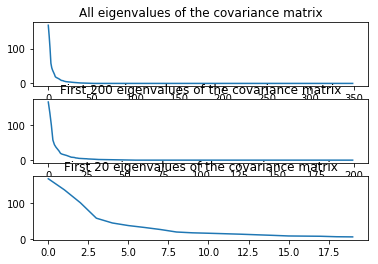

[[ 0.01581309 -0.00703613  0.00550157 ... -0.00395168  0.00246221
  -0.00629747]
 [ 0.00702386  0.00999271  0.01041875 ... -0.00417274  0.00379173
   0.00150621]
 [-0.01333204  0.00442626 -0.00803769 ...  0.00216822  0.00471694
  -0.00237641]
 ...
 [-0.07343256 -0.0411574  -0.00341291 ... -0.10773465  0.00577253
  -0.06199917]
 [ 0.1926808  -0.08186464 -0.04556179 ... -0.09920313  0.01346901
   0.08341649]
 [-0.07355276 -0.04814532 -0.04240626 ...  0.03891979  0.01458886
  -0.0552599 ]] (350, 30)


In [10]:
#calculate Wlda
#Get the generalised eigenvectors of LDA_matrix with largest Mlda eigenvalues
eigvals_LDA, eigvecs_LDA = np.linalg.eig(LDA)

# take real part of the eigenvalues (complex eigenvalues are the result of calculation rounding errors)
eigvals_LDA = np.real(eigvals_LDA)
eigvecs_LDA = np.real(eigvecs_LDA)

#order eigenvectors and eigenvalues according to their size
index_LDA = eigvals_LDA.argsort()[::-1]
eigvals_LDA = eigvals_LDA[index_LDA]
eigvecs_LDA = eigvecs_LDA[:,index_LDA]

x = np.arange(0, 350)
print (eigvals_LDA, eigvals_LDA.shape)

# plot them
plt.subplot(3, 1, 1)
plt.plot(x, eigvals_LDA) # clearly out of scale, so let's just take the first 200 of them
plt.title('All eigenvalues of the covariance matrix')

plt.subplot(3, 1, 2)
plt.plot(x[:200], eigvals_LDA[:200]) # still out of scale, so let's just take the first 20 of them
plt.title('First 200 eigenvalues of the covariance matrix')

plt.subplot(3, 1, 3)
plt.plot(x[:20], eigvals_LDA[:20])
plt.title('First 20 eigenvalues of the covariance matrix')
plt.show()

# We just keep the first Mlda eigenvectors and eigenvalues
Mlda = 30 #<=51
eigvecs_LDA_best = eigvecs_LDA[:, :Mlda]
eigvals_LDA_best = eigvals_LDA[:Mlda]

#Define Wpca
Wlda = eigvecs_LDA_best

print(Wlda, Wlda.shape)

[[ 2.01328758e-02  1.67226165e-02  1.09521004e-02 ...  3.14252485e-02
   9.03948648e-03 -7.72550382e-05]
 [ 2.59416507e-02  8.22232353e-03 -1.85419928e-02 ...  3.42258170e-02
   1.05449807e-02 -1.39903208e-02]
 [-1.72485721e-02  1.88967538e-02 -2.44544890e-03 ...  2.51657583e-02
  -1.59057837e-03  6.37445617e-03]
 ...
 [-1.23606887e-02 -1.76801946e-02  2.96555193e-02 ...  5.83200904e-03
  -6.87917392e-03  2.48326408e-02]
 [-2.07435578e-02 -1.54551107e-02  1.48274373e-02 ...  2.63358887e-03
   1.47653645e-02  1.07730213e-02]
 [-4.72171570e-02 -3.97574139e-02  6.35962572e-03 ... -1.61133702e-02
   1.83376862e-02 -1.20805932e-02]] (30, 2576)


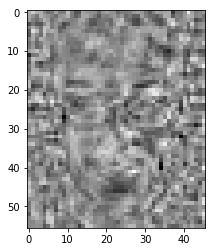

In [11]:
#Calculate Wopt
Wopt_transposed = Wlda.T.dot(Wpca.T)
print(Wopt_transposed,Wopt_transposed.shape)
Wopt = Wopt_transposed.T
plt.imshow(np.reshape(Wopt[:,0], (46,56)).T, cmap = 'gist_gray')

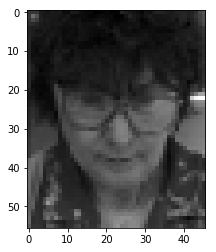

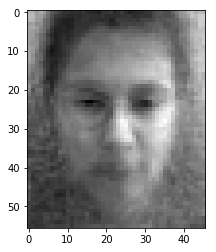

In [12]:
#Reconstruction check
plt.imshow(np.reshape(pca_train[0,:], (46,56)).T, cmap = 'gist_gray')
pic_LDA = Wopt_transposed.dot((pca_train[0,:]-global_mean))
pic_LDA_reconstructed = Wopt.dot(pic_LDA)+global_mean
plt.figure()
plt.imshow(np.reshape(pic_LDA_reconstructed, (46,56)).T, cmap = 'gist_gray')

In [13]:
#Nearest Neighbour Detection
#Project all classes into the LDA-Space
class_sets_LDA = []
for c in class_sets:
    class_sets_LDA.append(Wopt_transposed.dot((c-global_mean).T))

print(class_sets_LDA[0], class_sets_LDA[0].shape)


[[ 7.93297213e+00  9.18817597e+00  8.49147382e+00  9.71456657e+00
   8.36740010e+00  1.16739132e+01  1.03677193e+01  7.93097106e+00
   8.15237331e+00  9.96445558e+00]
 [ 1.04908692e+01  9.59253380e+00  9.14650920e+00  9.51544198e+00
   1.03366291e+01  1.17927352e+01  8.52523597e+00  9.12831563e+00
   5.55324133e+00  9.80375514e+00]
 [-1.26624945e+01 -1.62346751e+01 -1.57940624e+01 -1.54149227e+01
  -1.83106653e+01 -1.41984711e+01 -1.56992099e+01 -1.50926734e+01
  -1.49138446e+01 -1.63669433e+01]
 [-1.03614130e+01 -1.51598443e+01 -1.31150459e+01 -1.47535358e+01
  -1.48026310e+01 -1.53442395e+01 -1.31820495e+01 -1.60842083e+01
  -1.31043439e+01 -1.32780594e+01]
 [-7.59324549e+00 -7.94058839e+00 -8.14382742e+00 -7.78366801e+00
  -8.58443992e+00 -6.21831176e+00 -9.81239982e+00 -1.10570179e+01
  -5.98417982e+00 -5.98434412e+00]
 [-2.63001414e+01 -2.81200164e+01 -2.90345996e+01 -2.78845469e+01
  -2.97434689e+01 -2.54705323e+01 -3.07515753e+01 -2.78958157e+01
  -2.38698651e+01 -2.93568436e+01

(2576, 416)
(30, 416)
(2576, 104)
(30, 104)
(416, 104)
[185 286  26  47 204 142 191  61  43 350 155 149 127 206 315  31 300 274
 362 240 299 112  25  26 358 358 141 121 336 260  29 124 127 126  30  58
 391 306 394 127  24 286 260 411 256  58 237  96 324 108 326  89 129  31
  26 306 116  17 285  90 357 173  40 233  49  76 130 127 127  25 203 142
 125  69 404 379  29 306 130 146 105  54  73 403  32 326 337 178  31 154
  32 322 404 285  26 217  26 206 341  93 267 306  31 289]
[[0 0 2 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 1]]


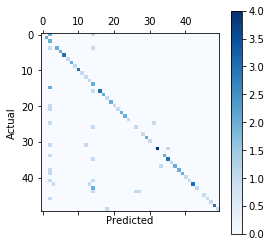

Percentage:  0.6923076923076923


In [17]:
#Predict the class for the test set
#Project train data into LDA space
train_norm = (training[:,:2576] - global_mean).T 
print(train_norm.shape) #each picture is a column
train_LDA = Wopt_transposed.dot(train_norm)
print(train_LDA.shape) #each picture is a column

#Project test data into LDA space
test_norm = (test[:,:2576] - global_mean).T 
print(test_norm.shape) #each picture is a column
test_LDA = Wopt_transposed.dot(test_norm)
print(test_LDA.shape) #each picture is a column

train_LDA = np.repeat(train_LDA.reshape(30,416,1),104, axis=2) #axis-0: projected values, axis-1: training pictures, axis-2: repeated values
test_LDA = np.repeat(test_LDA.reshape(30,1,104), 416, axis=1) #axis-0: projected values, axis-1: repeated values, axis-2: test pictures

#Do nearest neighbours
distances = np.linalg.norm(test_LDA-train_LDA, axis=0)
print(distances.shape)

#calculate the nearest training picture
nearest_trainpicture = distances.argmin(axis=0)
print(nearest_trainpicture)

#determine the nearest classes
classes_pred = training[nearest_trainpicture,2576]
classes_act = test[:,2576]

cm = confusion_matrix(classes_act, classes_pred)

print(cm)
plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

percentage = np.sum(classes_pred==classes_act) / len(classes_act)
print("Percentage: ",percentage)
